# **In this Colab, we wanted to try some basic models from sklearn to predict the sentence difficulty**

Here we instal and import all the library we potentially need for the project (some are not used here but for other Colab we can just copy paste this section)

In [2]:
!pip install nltk
!pip install transformers
!pip install PyTorch
!pip install TensorFlow

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for PyTorch
  Running setup.py clean for PyTorch
Failed to build PyTorch
ERROR: Could not build wheels for PyTorch, which is required to install pyproject.toml-based projects


In [ ]:
!pip install sentencepiece

In [3]:
#all the imports for our multiple file for the project. Some are not used here
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report
import joblib
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, CamembertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from tqdm import tqdm
import torch
import huggingface_hub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

We have our GIT repository here with the data files. So we clone it for the session and we just observe how is our data.

In [4]:
#load data

!git clone https://github.com/melvin2504/Detecting-the-difficulty-level-of-French-texts/ project_repo

Cloning into 'project_repo'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 74 (delta 6), reused 1 (delta 1), pack-reused 66
Receiving objects: 100% (74/74), 1.31 MiB | 3.71 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [5]:
df = pd.read_csv("/content/project_repo/data/training_data.csv")
unlabeled_df = pd.read_csv("/content/project_repo/data/unlabelled_test_data.csv")

In [ ]:
# Display the first few rows of the dataframe
df.head(20)

In [ ]:
# Basic info about the dataset
print(df.info())

In [ ]:
# Distribution of difficulty levels
print(df['difficulty'].value_counts())

### **Enhancing Textual Data with Linguistic Features**
In this section of the notebook, we aim to enrich our French textual dataset with various linguistic features. These additional features are intended to capture more nuanced aspects of the text, which can be highly beneficial for downstream Natural Language Processing (NLP) tasks, such as difficulty level assessment.

### **Overview of the Process**
We start by importing necessary NLP libraries: nltk for basic text processing functions and spacy for more advanced linguistic analysis. The spacy library, with its fr_core_news_lg model, is particularly adept at handling French language text.

### **Features Extracted**
**Sentence Length**: Measured as the number of words in a sentence. This feature can indicate the complexity and information density of the text.

**Average Word Length**: Computed as the average number of characters per word. This can be a marker of lexical sophistication or difficulty.

**Lexical Diversity**: Represents the ratio of unique words to the total number of words. Higher lexical diversity suggests richer vocabulary usage.

**Syntactic Complexity**: Assessed by counting the number of sentences within a text segment, using spacy's sentence parsing. This metric reflects the structural complexity of the text.

**Part-of-Speech (POS) Counts**: We utilize spacy to count the frequency of different grammatical categories (nouns, verbs, adjectives, etc.). This distribution can offer insights into the grammatical composition of the text.

### **Application to DataFrame**
Each feature extraction function is applied to the sentence column of our DataFrame df. The results are new columns, each representing a different linguistic feature. Additionally, we create a separate DataFrame pos_df for POS counts and concatenate it with our original DataFrame, allowing us to integrate all these features into our dataset.

**Purpose**

By incorporating these linguistic features, we aim to provide a more comprehensive dataset that encapsulates various aspects of language use. These features are expected to enhance the performance of machine learning models, enabling them to make more informed decisions based on a richer set of inputs.

In [6]:
!python -m spacy download fr_core_news_lg

2023-12-14 09:40:28.007771: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 09:40:28.007861: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 09:40:28.007901: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 09:40:30.886363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 MB 1.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_lg')


In [7]:

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
spacy_nlp = spacy.load('fr_core_news_lg')
nltk.download('wordnet')






def sentence_length(sentence):
    return len(word_tokenize(sentence, language='french'))

def avg_word_length(sentence):
    words = word_tokenize(sentence, language='french')
    return sum(len(word) for word in words) / len(words) if words else 0

def lexical_diversity(sentence):
    words = word_tokenize(sentence, language='french')
    return len(set(words)) / len(words) if words else 0

def syntactic_complexity(sentence):
    doc = spacy_nlp(sentence)
    return sum(1 for _ in doc.sents)  # Example: counting number of sentences

# Apply the functions to the dataframe
df['sentence_length'] = df['sentence'].apply(sentence_length)
df['avg_word_length'] = df['sentence'].apply(avg_word_length)
df['lexical_diversity'] = df['sentence'].apply(lexical_diversity)
df['syntactic_complexity'] = df['sentence'].apply(syntactic_complexity)

# For POS counts, create a function that returns a dictionary of counts
def pos_counts(sentence):
    doc = spacy_nlp(sentence)
    counts = {}
    for token in doc:
        counts[token.pos_] = counts.get(token.pos_, 0) + 1
    return counts

# Apply the POS count function
df_pos = df['sentence'].apply(pos_counts)
pos_df = pd.DataFrame(list(df_pos))
df = pd.concat([df, pos_df], axis=1)

# Display the first few rows with new features
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,id,sentence,difficulty,sentence_length,avg_word_length,lexical_diversity,syntactic_complexity,DET,NOUN,ADJ,...,PUNCT,CCONJ,PRON,AUX,PROPN,SCONJ,NUM,SYM,X,INTJ
0,0,Les coûts kilométriques réels peuvent diverger...,C1,44,4.954545,0.704545,1,3.0,14.0,3.0,...,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,14,3.642857,1.000000,1,3.0,3.0,1.0,...,2.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Le test de niveau en français est sur le site ...,A1,14,3.857143,0.928571,1,3.0,4.0,1.0,...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,3,Est-ce que ton mari est aussi de Boston?,A1,9,3.666667,1.000000,1,1.0,2.0,NaN,...,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,4,"Dans les écoles de commerce, dans les couloirs...",B1,39,4.564103,0.794872,1,5.0,10.0,2.0,...,5.0,1.0,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN


### **Integrating TF-IDF and Linguistic Features**
In this section, we merge textual and linguistic features to enhance our dataset's representation for machine learning models:


1.   **TF-IDF Vectorization**: We convert the sentences from df['sentence'] into a
TF-IDF matrix, considering unigrams, bigrams, and trigrams.

2.   **Linguistic Features**: Extracted features such as 'sentence_length', 'avg_word_length', 'lexical_diversity', and 'syntactic_complexity' are prepared for integration.

3. **Sparse Matrix Conversion**: These linguistic features are converted to a Compressed Sparse Row (CSR) format.

4. **Feature Combination**: We horizontally stack the TF-IDF matrix with the CSR matrix of linguistic features, creating a unified feature set X_combined.

This combined feature set, capturing both text content and linguistic characteristics, is designed to provide a richer input for our predictive models.

In [8]:
from scipy.sparse import hstack, csr_matrix

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=3, max_df=0.8)

# Transform the text data to TF-IDF features
X_text = vectorizer.fit_transform(df['sentence'])

# Extract additional features and convert to a CSR (Compressed Sparse Row) format
additional_features = df[['sentence_length', 'avg_word_length', 'lexical_diversity', 'syntactic_complexity']] # Add any other features you created
additional_features_csr = csr_matrix(additional_features)

# Combine TF-IDF features with additional features
X_combined = hstack([X_text, additional_features_csr])

In [ ]:
print(X_combined)

  (0, 2402)	0.16654270563945978
  (0, 5222)	0.16654270563945978
  (0, 2632)	0.17126652182198582
  (0, 2059)	0.17126652182198582
  (0, 1730)	0.06991817079382164
  (0, 7555)	0.15409961175131104
  (0, 5607)	0.15659300852026906
  (0, 2401)	0.3253661335732969
  (0, 1917)	0.14800955348493164
  (0, 5220)	0.14800955348493164
  (0, 3265)	0.17126652182198582
  (0, 2630)	0.14631509699907497
  (0, 2120)	0.15941978863396705
  (0, 4568)	0.16654270563945978
  (0, 3040)	0.15409961175131104
  (0, 7729)	0.15941978863396705
  (0, 3254)	0.17126652182198582
  (0, 4727)	0.15659300852026906
  (0, 3992)	0.043448387748418194
  (0, 8101)	0.15941978863396705
  (0, 3760)	0.17126652182198582
  (0, 5601)	0.08217683808413835
  (0, 5498)	0.17126652182198582
  (0, 7554)	0.2960191069698633
  (0, 8100)	0.17126652182198582
  :	:
  (4798, 8522)	1.0
  (4799, 8113)	0.29154250736275933
  (4799, 7465)	0.2998118170805673
  (4799, 4487)	0.2998118170805673
  (4799, 7024)	0.27907343478738167
  (4799, 6742)	0.26232365665550017
  (

### **Final Preprocessing Steps: Encoding Labels and Splitting Data**
Before training our machine learning models, we perform two crucial preprocessing steps:

## 1. **Label Encoding**:


*   **Purpose**: Convert categorical labels (text-based) into numerical form. This is essential because most machine learning algorithms require numerical input.
*   **Method**: We use LabelEncoder from scikit-learn, which assigns a unique integer to each category of the label.


## 2. **Train-Test Split**:


*   **Purpose**: To evaluate the model effectively, we need to test it on unseen data. This is why we split the dataset into training and testing sets.
*   **Method**: We employ train_test_split from scikit-learn. Typically, the dataset is divided into around 70-80% training data and 20-30% testing data. This split allows the model to learn from a substantial portion of the data and be validated on a separate portion.
* **Random State**: A fixed random_state is often used to ensure reproducibility of the split.

In [9]:


# Initialize the label encoder
encoder = LabelEncoder()

# Fit and transform the difficulty levels
y = encoder.fit_transform(df['difficulty'])

In [10]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

## Model Training and Hyperparameter Tuning

In this section, we train various machine learning models, each with its unique strengths, and perform hyperparameter tuning to optimize their performance. Here's a brief overview:

### 1. XGBoost:
- **Strengths**: Highly efficient, flexible, and capable of handling sparse data.
- **Key Hyperparameters**:
  - `n_estimators`: Number of boosting rounds.
  - `max_depth`: Maximum tree depth.
  - `learning_rate`: Step size shrinkage.
  - `gamma`: Minimum loss reduction to make a further partition.
  - `subsample`: Subsample ratio of the training instances.

### 2. Logistic Regression:
- **Strengths**: Simple, efficient, and interpretable.
- **Key Hyperparameters**: Regularization strength (`C`) and the type of solver.

### 3. K-Nearest Neighbors (KNN):
- **Strengths**: Simple and effective, especially for small datasets.
- **Key Hyperparameters**: Number of neighbors (`n_neighbors`) and distance metric.

### 4. Decision Tree:
- **Strengths**: Easy to interpret, non-parametric.
- **Key Hyperparameters**: Maximum depth of the tree (`max_depth`), and minimum samples required to split an internal node (`min_samples_split`).

### 5. Random Forest:
- **Strengths**: Robust, handles overfitting well.
- **Key Hyperparameters**: Number of trees (`n_estimators`), maximum depth of trees (`max_depth`).

### 6. SVM (Support Vector Machine):
- **Strengths**: Effective in high dimensional spaces.
- **Key Hyperparameters**: Regularization (`C`), kernel type (`kernel`), and kernel coefficient (`gamma`).

### Training and Evaluation:
For each model, we perform the following steps:
1. **Hyperparameter Tuning**: Using `GridSearchCV` to find the optimal settings.
2. **Model Training**: Training the model with the best-found parameters on the training set.
3. **Prediction and Metrics Calculation**: Making predictions on the test set and calculating performance metrics such as precision, recall, F1 score, and accuracy.

These steps ensure that each model is finely tuned and evaluated, providing a comprehensive understanding of their performance on our dataset.


### **XGBoost model**

In [ ]:
from xgboost import XGBClassifier

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 500],
    'max_depth': [1,10],
    'learning_rate': [0.01, 0.1],
    'gamma': [1, 5],
    'subsample': [0.8, 1.0],

}

# Initialize the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy')

# Fit the model
# Assuming X_train and y_train are already defined
grid_search_xgb.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters for XGBoost: ", grid_search_xgb.best_params_)
print("Best Score for XGBoost: ", grid_search_xgb.best_score_)

Best Parameters for XGBoost:  {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500, 'subsample': 0.8}
Best Score for XGBoost:  0.4393229166666667


In [ ]:
# Initialize and train the XGBoost model with the best parameters
best_params = grid_search_xgb.best_params_
model_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss')
model_xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = model_xgb.predict(X_test)

# Calculate metrics
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_score_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

### **Logistic Regression model**

In [ ]:
# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization
    'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
}

# Initialize the Logistic Regression model
logistic_regression = LogisticRegression()

# Initialize GridSearchCV
grid_search_lr = GridSearchCV(logistic_regression, param_grid_lr, cv=5, scoring='accuracy')

# Fit the model
# Assuming X_train and y_train are already defined
grid_search_lr.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters for Logistic Regression: ", grid_search_lr.best_params_)
print("Best Score for Logistic Regression: ", grid_search_lr.best_score_)

In [12]:
best_params = grid_search_lr.best_params_


# Initialize and train the Logistic Regression model
model_lr = LogisticRegression(**best_params)
model_lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_test)

# Calculate metrics
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_score_lr = f1_score(y_test, y_pred_lr, average='weighted')
accuracy_lr = accuracy_score(y_test, y_pred_lr)

### **KNN model**

In [13]:
# Define the parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10, 15]
}

# Initialize the kNN model
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')

# Fit the model
grid_search_knn.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters for kNN: ", grid_search_knn.best_params_)
print("Best Score for kNN: ", grid_search_knn.best_score_)

Best Parameters for kNN:  {'n_neighbors': 7}
Best Score for kNN:  0.3690104166666667


In [14]:
# Initialize and train the kNN model
best_params = grid_search_knn.best_params_
model_knn = KNeighborsClassifier(**best_params)
model_knn.fit(X_train, y_train)

# Make predictions
y_pred_knn = model_knn.predict(X_test)

# Calculate metrics
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_score_knn = f1_score(y_test, y_pred_knn, average='weighted')
accuracy_knn = accuracy_score(y_test, y_pred_knn)

### **Decision Tree model**

In [ ]:
# Define the parameter grid
param_grid_dt = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Decision Tree model
decision_tree = DecisionTreeClassifier()

# Initialize GridSearchCV
grid_search_dt = GridSearchCV(decision_tree, param_grid_dt, cv=5, scoring='accuracy')

# Fit the model
grid_search_dt.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters for Decision Tree: ", grid_search_dt.best_params_)
print("Best Score for Decision Tree: ", grid_search_dt.best_score_)

Best Parameters for Decision Tree:  {'max_depth': 10, 'min_samples_split': 5}
Best Score for Decision Tree:  0.37994791666666666


In [ ]:
best_params = grid_search_dt.best_params_

# Initialize and train the Decision Tree model
model_dt = DecisionTreeClassifier(**best_params)
model_dt.fit(X_train, y_train)

# Make predictions
y_pred_dt = model_dt.predict(X_test)

# Calculate metrics
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_score_dt = f1_score(y_test, y_pred_dt, average='weighted')
accuracy_dt = accuracy_score(y_test, y_pred_dt)

### **Random Forest model**

In [ ]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Random Forest model
random_forest = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(random_forest, param_grid_rf, cv=5, scoring='accuracy')

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters for Random Forest: ", grid_search_rf.best_params_)
print("Best Score for Random Forest: ", grid_search_rf.best_score_)

Best Parameters for Random Forest:  {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Best Score for Random Forest:  0.44609375


In [ ]:
best_params = grid_search_rf.best_params_
# Initialize and train the Random Forest model

model_rf = RandomForestClassifier(**best_params)
model_rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = model_rf.predict(X_test)

# Calculate metrics
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_score_rf = f1_score(y_test, y_pred_rf, average='weighted')
accuracy_rf = accuracy_score(y_test, y_pred_rf)

### **SVM (Support Vector Machine) model**

In [ ]:
from sklearn.svm import SVC
# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],  # Type of kernel
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Initialize the SVM model
svm_model = SVC()

# Initialize GridSearchCV
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy')

# Fit the model
# Assuming X_train and y_train are already defined
grid_search_svm.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters for SVM: ", grid_search_svm.best_params_)
print("Best Score for SVM: ", grid_search_svm.best_score_)


Best Parameters for SVM:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score for SVM:  0.4768229166666667


In [ ]:
# Initialize and train the SVM model with the best parameters
best_params = grid_search_svm.best_params_
model_svm = SVC(C=best_params['C'], kernel=best_params['kernel'], gamma=best_params['gamma'])
model_svm.fit(X_train, y_train)

# Make predictions
y_pred_svm = model_svm.predict(X_test)

# Calculate metrics
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_score_svm = f1_score(y_test, y_pred_svm, average='weighted')
accuracy_svm = accuracy_score(y_test, y_pred_svm)

## Model Performance Comparison

After training and evaluating all models, we aggregate their performance metrics into a single DataFrame for easy comparison:

- The DataFrame `metrics_df` includes:
  - `Model`: Names of the models (Logistic Regression, kNN, Decision Tree, Random Forests, SVM, XGBoost).
  - `Precision`: The precision score for each model.
  - `Recall`: The recall score for each model.
  - `F1-Score`: The F1 score for each model, balancing precision and recall.
  - `Accuracy`: The accuracy score for each model.

### Highlighting the Best Performances

To easily identify the best-performing model in each metric, we apply a highlighting function:
- The function `highlight_max` is used to highlight the maximum value in each metric column.
- This makes it immediately apparent which model excels in which particular metric.

### Visualization
We then apply this highlighting function to our DataFrame and display the styled DataFrame. This provides a clear and visually appealing comparison of the model performances.


In [ ]:
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'kNN', 'Decision Tree', 'Random Forests', 'SVM', 'XGBoost'],
    'Precision': [precision_lr, precision_knn, precision_dt, precision_rf, precision_svm, precision_xgb],
    'Recall': [recall_lr, recall_knn, recall_dt, recall_rf, recall_svm, recall_xgb],
    'F1-Score': [f1_score_lr, f1_score_knn, f1_score_dt, f1_score_rf, f1_score_svm, f1_score_xgb],
    'Accuracy': [accuracy_lr, accuracy_knn, accuracy_dt, accuracy_rf, accuracy_svm, accuracy_xgb]
})
def highlight_max(s):
    '''
    Highlight the maximum value in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Applying the highlight function to our DataFrame
styled_df = metrics_df.style.apply(highlight_max, subset=['Precision', 'Recall', 'F1-Score', 'Accuracy'])

# Display the styled DataFrame
styled_df

,Model,Precision,Recall,F1-Score,Accuracy
0,Logistic Regression,0.458717,0.467708,0.457882,0.467708
1,kNN,0.340016,0.346875,0.335963,0.346875
2,Decision Tree,0.406695,0.408333,0.400994,0.408333
3,Random Forests,0.426190,0.435417,0.423571,0.435417
4,SVM,0.475693,0.482292,0.476856,0.482292
5,XGBoost,0.446759,0.451042,0.447470,0.451042


## Confusion Matrix Visualization for Each Model

To gain a deeper understanding of each model's performance, we visualize the confusion matrices. A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known.

### Process Overview:

1. **Models List**: We have a list of models along with their respective prediction outcomes. This includes Logistic Regression, K-Nearest Neighbors (kNN), Decision Tree, Random Forest, Support Vector Machine (SVM), and XGBoost.

2. **Iteration and Visualization**:
   - For each model, we iterate through its predictions.
   - We compute the confusion matrix using the `confusion_matrix` function from scikit-learn, comparing the predicted labels (`model_predictions`) against the true labels (`y_test`).

3. **Plotting**:
   - Each confusion matrix is visualized using a heatmap from the seaborn library.
   - The heatmap provides an intuitive color-coded representation of the confusion matrix, where the color intensity corresponds to the number of instances in each cell of the matrix.

### Code for Plotting:

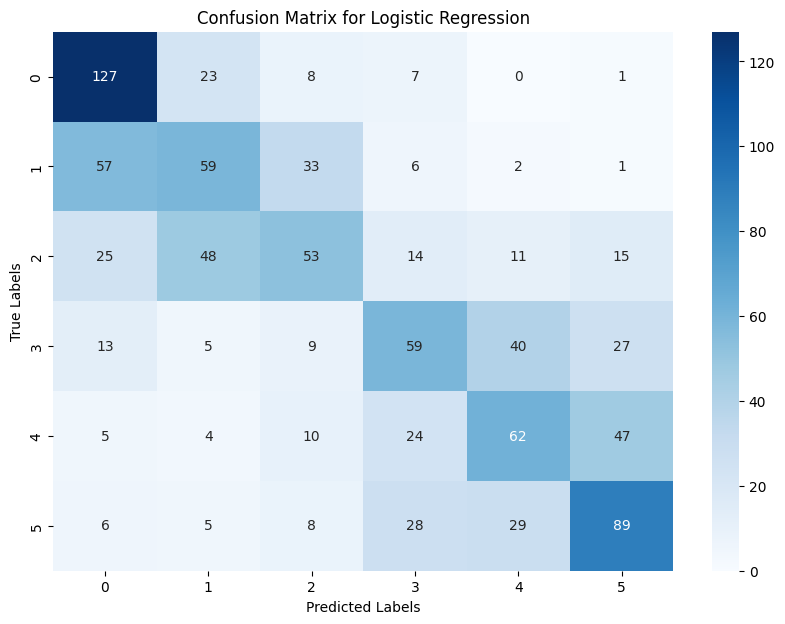

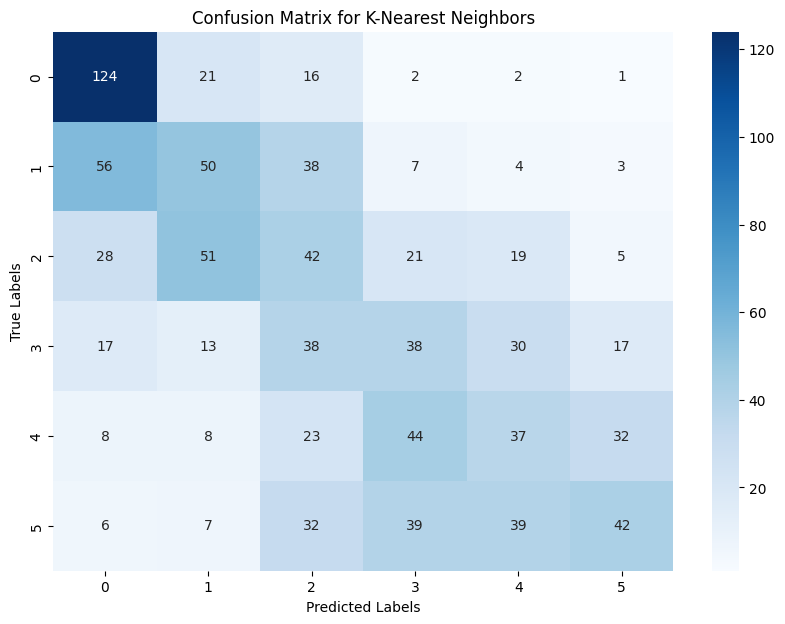

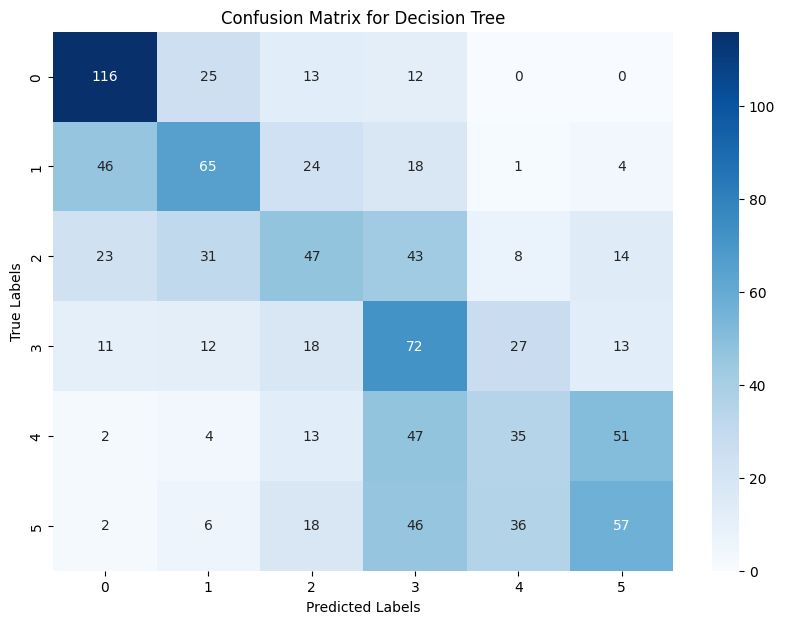

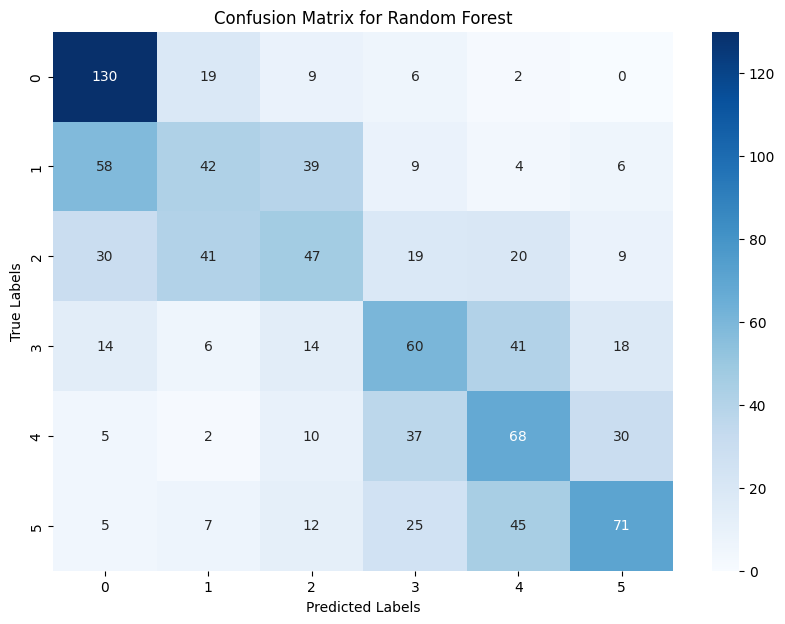

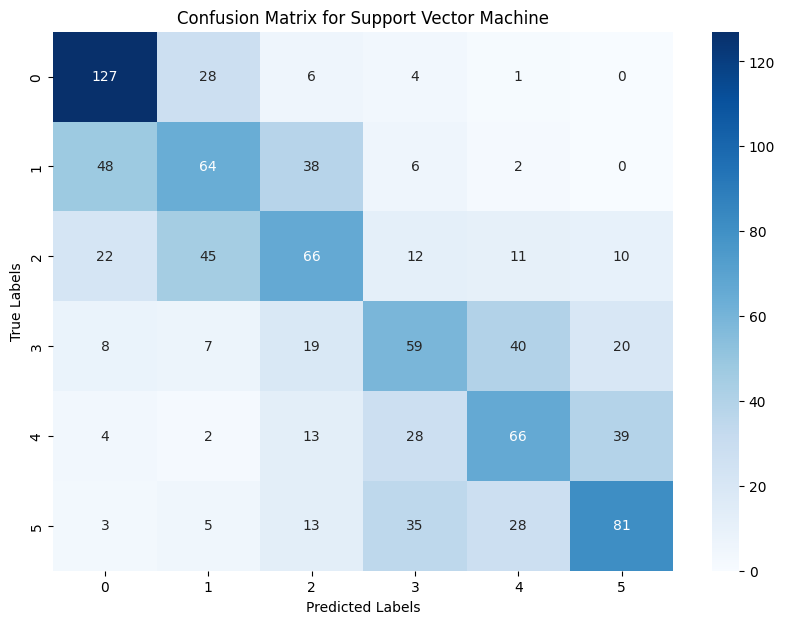

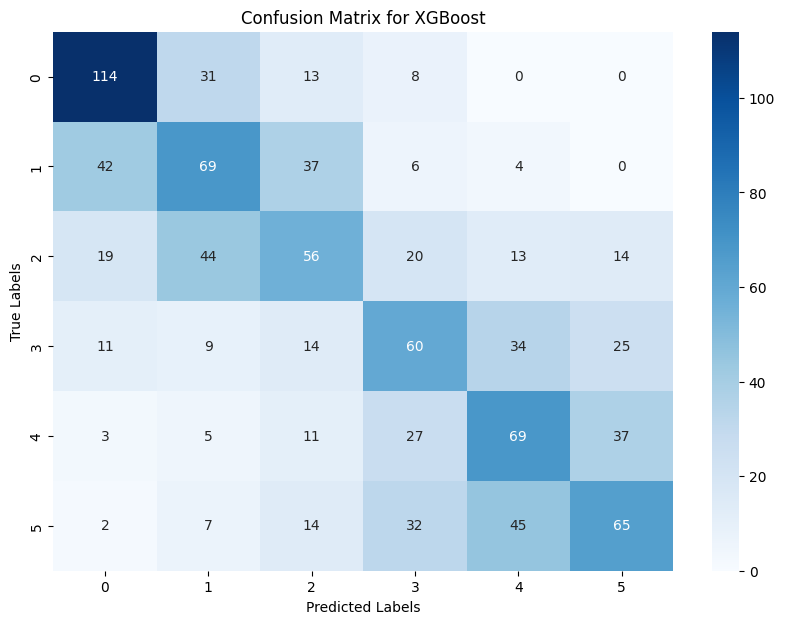

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define a list of models and their corresponding prediction labels
models = [
    ("Logistic Regression", y_pred_lr),
    ("K-Nearest Neighbors", y_pred_knn),
    ("Decision Tree", y_pred_dt),
    ("Random Forest", y_pred_rf),
    ("Support Vector Machine", y_pred_svm),
    ("XGBoost", y_pred_xgb)
]

# Iterate over the models and plot confusion matrix for each
for model_name, model_predictions in models:
    # Compute confusion matrix for each model
    conf_matrix = confusion_matrix(y_test, model_predictions)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


## Saving and Downloading Trained Models

To preserve the trained state of our machine learning models for future use, we are saving them to disk. This process is crucial for deploying models in production or for further analysis without the need to retrain.

### Process Overview:

1. **Defining File Paths**:
   - We specify the paths where each model will be saved. The file format used is `.joblib`, which is efficient for storing large arrays such as those in machine learning models.

2. **Saving Models**:
   - We utilize `joblib.dump` to serialize and save each trained model to the defined paths.
   - This includes Logistic Regression, K-Nearest Neighbors, Decision Tree, Random Forest, Support Vector Machine, and XGBoost models.

3. **Potential Issue with Large Models**:
   - Saving large models like Random Forest might encounter issues due to their size, especially in cloud-based environments where there could be limitations on file sizes or available disk space.
   - If you encounter difficulties in downloading a large model, consider checking the available disk space or compressing the model file.

4. **Manual Download**:
   - In cloud-based environments like Google Colab, if automatic download fails, particularly for large files, you may need to use environment-specific functions to manually trigger the download.

### Code for Saving Models:

In [ ]:
import joblib

# Define the paths for saving each model
paths = {
    "model_lr": "model_lr.joblib",
    "model_knn": "model_knn.joblib",
    "model_dt": "model_dt.joblib",
    "model_rf": "model_rf.joblib",
    "model_svm": "model_svm.joblib",
    "model_xgb": "model_xgb.joblib",
}
#I can't download the rf one I don't know why
# Save each model
for model_name, model in [("model_lr", model_lr), ("model_knn", model_knn), ("model_dt", model_dt), ("model_rf", model_rf), ("model_svm", model_svm), ("model_xgb", model_xgb)]:
    joblib.dump(model, paths[model_name])
    print(f"Saved {model_name} at {paths[model_name]}")


Saved model_lr at model_lr.joblib
Saved model_knn at model_knn.joblib
Saved model_dt at model_dt.joblib
Saved model_rf at /content/model_rf.joblib
Saved model_svm at model_svm.joblib
Saved model_xgb at model_xgb.joblib


## Retraining the Selected Model on Full Data

After evaluating multiple models and selecting the best performer, we proceed to retrain this model on the entire dataset. This step is crucial for leveraging the maximum amount of data available, potentially improving the model's performance and generalizability.

### Process Overview:

1. **Model Selection**:
   - Based on the performance metrics (such as precision, recall, F1-score, and accuracy) evaluated earlier, we choose the model that showed the best results or fits our requirements the most.

2. **Full Dataset Utilization**:
   - Unlike the initial training phase where we split the data into training and testing sets, here we use the entire dataset for training. This maximizes the learning potential of the model.

3. **Retraining**:
   - The selected model is retrained from scratch on the full dataset. This ensures that it learns from all available data, potentially capturing more patterns and insights.

4. **Deployment Readiness**:
   - The retrained model is now ready for deployment in a production environment or for further application, as it is trained on the complete dataset.

### Example Code for Retraining:

In [ ]:
model_lr.fit(X_combined, y)

## Predicting Unlabeled Data

Having trained our model on the full dataset, we now apply it to make predictions on new, unlabeled data. This step is crucial for practical applications, as it demonstrates the model's ability to generalize and provide insights on data it has not seen before.

### Process Overview:

1. **Data Preparation**:
   - We ensure that the unlabeled data is processed and formatted in the same way as our training data, maintaining consistency in feature representation.

2. **Model Application**:
   - The trained model is used to predict the labels of the unlabeled dataset. This is the step where the model applies its learned patterns to new data.

3. **Result Utilization**:
   - The predictions can be used for various purposes, depending on the project's goal. It could be for making informed decisions, further analysis, or as input to another stage in a larger pipeline.

### Example Code for Prediction:

In [ ]:
# Apply the functions to the dataframe
unlabeled_df['sentence_length'] =unlabeled_df['sentence'].apply(sentence_length)
unlabeled_df['avg_word_length'] = unlabeled_df['sentence'].apply(avg_word_length)
unlabeled_df['lexical_diversity'] = unlabeled_df['sentence'].apply(lexical_diversity)
unlabeled_df['syntactic_complexity'] = unlabeled_df['sentence'].apply(syntactic_complexity)
# Apply the POS count function
unlabeled_df_pos = unlabeled_df['sentence'].apply(pos_counts)
pos_df = pd.DataFrame(list(unlabeled_df_pos))
unlabeled_df = pd.concat([unlabeled_df, pos_df], axis=1)

In [ ]:
# Transform the text data to TF-IDF features
X_unlabeled = vectorizer.fit_transform(unlabeled_df['sentence'])

# Extract additional features and convert to a CSR (Compressed Sparse Row) format
additional_features = unlabeled_df[['sentence_length', 'avg_word_length', 'lexical_diversity', 'syntactic_complexity']]
additional_features_csr = csr_matrix(additional_features)

# Combine TF-IDF features with additional features
X_combined_unlabeled = hstack([X_unlabeled, additional_features_csr])

In [ ]:
# Predicting the difficulty levels
predicted_difficulties = model_lr.predict(X_combined_unlabeled)

predicted_labels = encoder.inverse_transform(predicted_difficulties)


## Preparing Predictions for Kaggle Submission

After obtaining predictions on the unlabeled dataset, the next step is to format these predictions for submission to Kaggle. This involves structuring the data according to Kaggle's submission requirements, typically in a CSV file with specific columns.

### Process Overview:

1. **Creating Submission DataFrame**:
   - We create a new DataFrame that aligns with the expected submission format of Kaggle. This usually involves including an 'id' column and a column for predictions.

2. **Inserting Predictions**:
   - The predictions made by our model are inserted into the DataFrame, ensuring they match the corresponding ids of the unlabeled data.

3. **Exporting to CSV**:
   - The DataFrame is then exported to a CSV file, which is the format generally accepted for Kaggle submissions.

4. **Submission Ready**:
   - The CSV file can now be submitted to the appropriate Kaggle competition.

### Example Code for Kaggle Submission:

In [ ]:
# Prepare the DataFrame for submission
submission_df = pd.DataFrame({
    'id': unlabeled_df['id'],
    'difficulty': predicted_labels
})

# Save the DataFrame to a CSV file
submission_file = 'submission_v2.csv'
submission_df.to_csv(submission_file, index=False)